# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [467]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


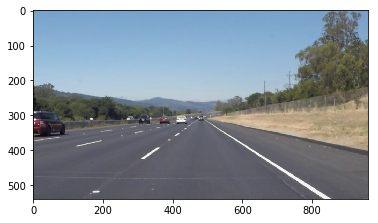

In [468]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [589]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img) 
      
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # I don't trust using slopes to distinguish between left and right lines. 
    # turning left or right can make one line more or less negative or positive
    # in slope than another. also, a verticle line could give us a divide by zero error. 
    
    # I will try it for now, but I expect it to give me problems later. 
    

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
 
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    
    mid_x = img.shape[1]/2
    
    for line in lines: 
        for x1,y1,x2,y2 in line:
             
            if(x1 < mid_x):
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)
            else:
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
   
    if(len(left_x) > 0):
        left_m, left_b = np.polyfit(left_x,left_y,1) 
    if(len(right_x) > 0):
        right_m, right_b = np.polyfit(right_x, right_y,1)

    max_x = img.shape[1]
    max_y = img.shape[0]
    
    line_bottom_y = max_y
    left_line_top_y = np.min(left_y)
    right_line_top_y = np.min(right_y)
    line_top_y = min(left_line_top_y, right_line_top_y)
    
    left_line_bottom_x = int((line_bottom_y - left_b)/left_m)
    left_line_top_x = int((line_top_y - left_b)/left_m)
    
    right_line_bottom_x = int((line_bottom_y - right_b)/right_m)
    right_line_top_x = int((line_top_y - right_b)/right_m)
 
    cv2.line(img, (left_line_bottom_x, line_bottom_y), (left_line_top_x,line_top_y),[0,255,0], thickness)
    cv2.line(img, (right_line_bottom_x, line_bottom_y), (right_line_top_x,line_top_y),[0,255,0], thickness)
     

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [590]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

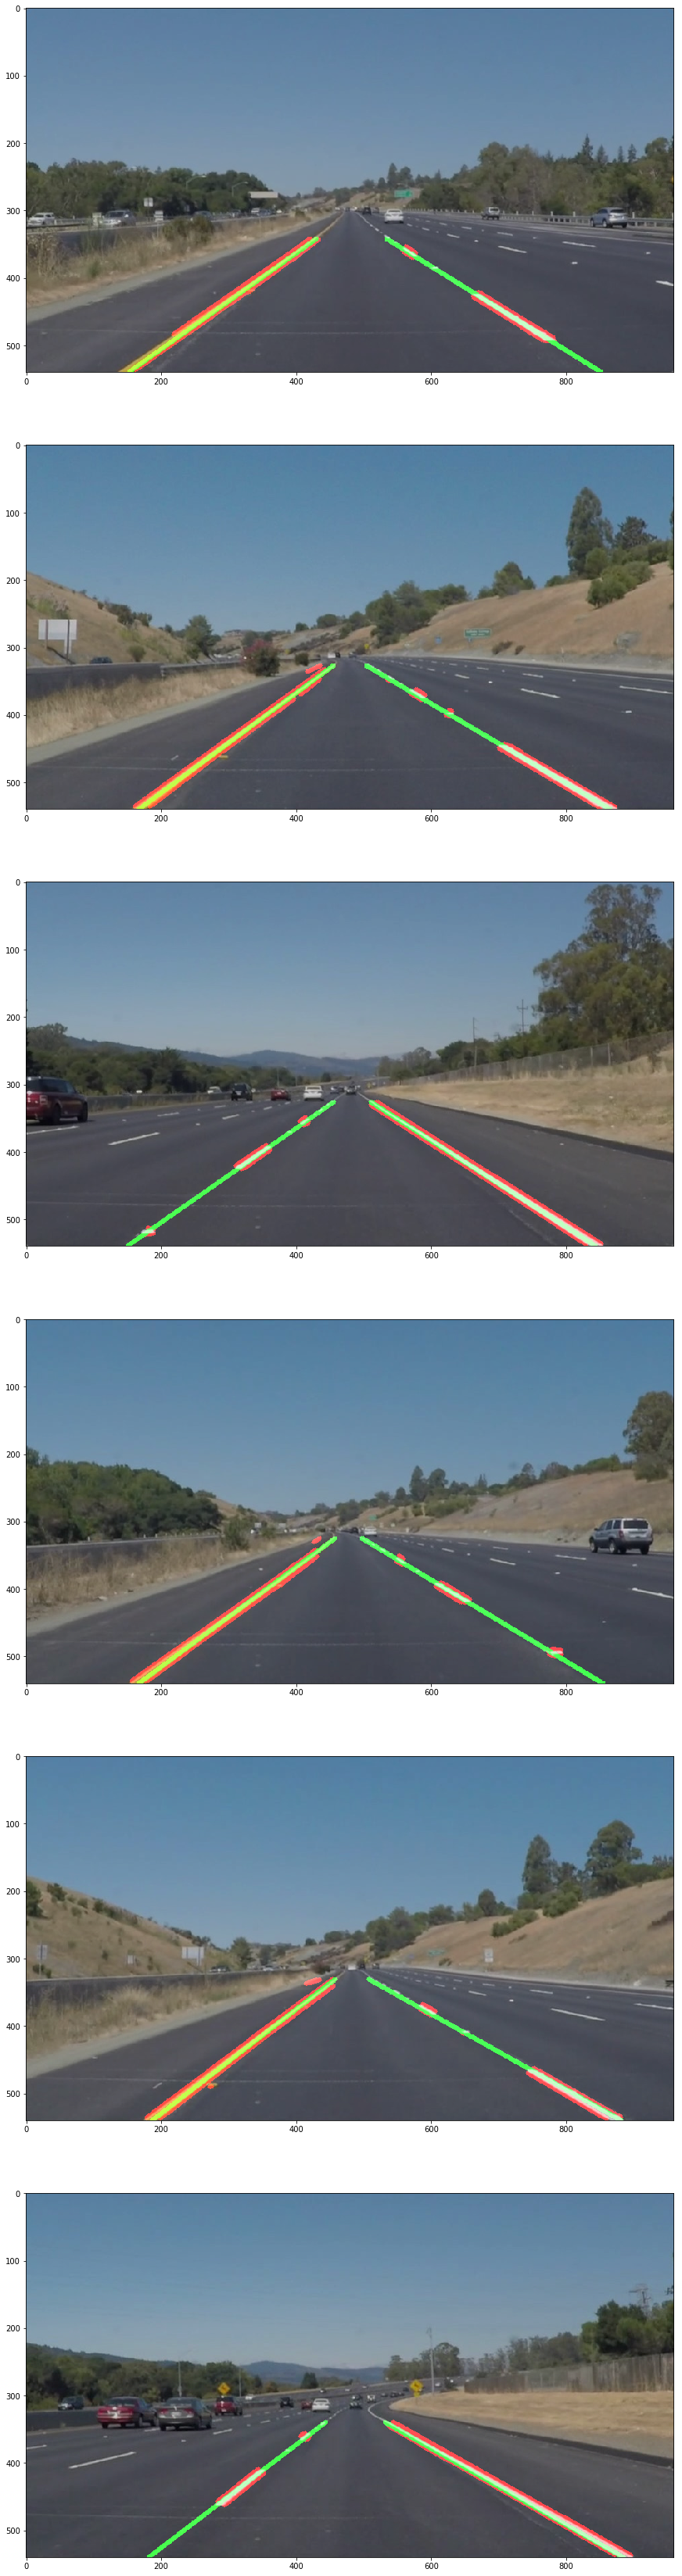

In [609]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def pipeline(img, name="image"):
    # canny settings
    canny_low_threshold = 20
    canny_high_threshold = 40

    # blur settings
    kernel = 25

    # masking settings
    top_left_x = 0.45    #percent of X for top vertex of mask area
    top_left_y = 0.6    #percent of Y for top vertex of mask area
    bottom_left_x = 0.15   #percent of X for left vertex of mask area
    bottom_left_y = 1   #percent of Y for left vertex of mask area
    top_right_x = 0.55  #percent of X for right vertex of mask area
    top_right_y = 0.6    #percent of Y for right vertex of mask area
    bottom_right_x = 0.95  #percent of X for right vertex of mask area
    bottom_right_y = 1    #percent of Y for right vertex of mask area

    # Hough settings
    rho = 1        # distance resolution, hough
    theta = np.pi/360 #angular resolution, hough
    threshold = 10 #minimum number of intersections in Hough to call it a line
    min_line_len = 1 #least pixels we can call a line
    max_line_gap = 5 #biggest allowable gap between pixels we can call a line 


    # get the image
    
    init_image = np.copy(img)
 
    #greyscale it
    image=grayscale(img)
    mpimg.imsave("test_images_output/" + name + "-grey.png",image,cmap="gray")
    
    #apply gauss blur
    image=gaussian_blur(image,kernel)
    mpimg.imsave("test_images_output/" + name + "-gauss.png",image,cmap="gray")
    
    #apply canny transform
    image=canny(image,canny_low_threshold, canny_high_threshold)
    mpimg.imsave("test_images_output/" + name + "-canny.png",image,cmap="gray")
    
    #select our region to care about
    shape=image.shape
    v1=(bottom_left_x*shape[1],bottom_left_y*shape[0])    #bottom left
    v2=(top_left_x*shape[1],top_left_y*shape[0])   #top left 
    v3=(top_right_x*shape[1],top_right_y*shape[0]) # top right
    v4=(bottom_right_x*shape[1],bottom_right_y*shape[0])   #bottom right
    vertices=np.array([[v1,v2,v3,v4]], dtype=np.int32)
    image=region_of_interest(image, vertices)
    mpimg.imsave("test_images_output/" + name + "-masked.png",image)
    
    # apply hough transform
    
    image=hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap)
    mpimg.imsave("test_images_output/" + name + "-hough.png",image)
    
    # now let's map it onto the original image
    image=weighted_img(img=image,initial_img=init_image,α=0.8, β=2., λ=0.)
    mpimg.imsave("test_images_output/" + name + "-final.png",image)
    
    return image
# display settings
image_number=1 #counter for the subplot of the images
plt_rows = 6
plt_cols = 1

f=plt.figure(figsize=(20,60))

for img in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + img)
    image = pipeline(image,img)
    plt.subplot(plt_rows,plt_cols,image_number)
    plt.imshow(image)
    image_number += 1
plt.show()




## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [597]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [598]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [599]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4







  0%|          | 0/222 [00:00<?, ?it/s]




  2%|▏         | 4/222 [00:00<00:06, 34.95it/s]




  4%|▍         | 9/222 [00:00<00:05, 37.28it/s]




  7%|▋         | 15/222 [00:00<00:05, 40.45it/s]




  9%|▊         | 19/222 [00:00<00:05, 40.15it/s]




 11%|█▏        | 25/222 [00:00<00:04, 42.22it/s]




 14%|█▎        | 30/222 [00:00<00:04, 43.13it/s]




 16%|█▌        | 35/222 [00:00<00:04, 42.08it/s]




 18%|█▊        | 40/222 [00:00<00:04, 42.80it/s]




 20%|██        | 45/222 [00:01<00:04, 41.81it/s]




 23%|██▎       | 50/222 [00:01<00:04, 35.83it/s]




 24%|██▍       | 54/222 [00:01<00:04, 33.65it/s]




 26%|██▌       | 58/222 [00:01<00:05, 30.64it/s]




 28%|██▊       | 62/222 [00:01<00:05, 29.40it/s]




 30%|██▉       | 66/222 [00:01<00:05, 28.74it/s]




 31%|███       | 69/222 [00:01<00:05, 27.46it/s]




 32%|███▏      | 72/222 [00:02<00:05, 27.12it/s]




 34%|███▍      | 75/222 [00:02<00:05, 26.47it/s]




 35%|███▌      | 78/222 [00:02<00:05, 25.91it/s]





[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.38 s, sys: 404 ms, total: 3.79 s
Wall time: 9.18 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [600]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [601]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4







  0%|          | 0/682 [00:00<?, ?it/s]




  0%|          | 3/682 [00:00<00:24, 28.19it/s]




  1%|          | 8/682 [00:00<00:21, 31.05it/s]




  2%|▏         | 13/682 [00:00<00:19, 33.50it/s]




  2%|▏         | 17/682 [00:00<00:19, 34.68it/s]




  3%|▎         | 22/682 [00:00<00:17, 36.78it/s]




  4%|▍         | 26/682 [00:00<00:17, 37.40it/s]




  5%|▍         | 31/682 [00:00<00:16, 39.23it/s]




  5%|▌         | 35/682 [00:00<00:16, 39.16it/s]




  6%|▌         | 40/682 [00:01<00:15, 40.73it/s]




  7%|▋         | 45/682 [00:01<00:16, 39.79it/s]




  7%|▋         | 49/682 [00:01<00:17, 37.14it/s]




  8%|▊         | 53/682 [00:01<00:18, 33.72it/s]




  8%|▊         | 57/682 [00:01<00:20, 30.64it/s]




  9%|▉         | 61/682 [00:01<00:20, 30.37it/s]




 10%|▉         | 65/682 [00:01<00:22, 28.03it/s]




 10%|▉         | 68/682 [00:01<00:22, 26.93it/s]




 10%|█         | 71/682 [00:02<00:22, 26.61it/s]




 11%|█         | 75/682 [00:02<00:22, 26.40it/s]





[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10.8 s, sys: 960 ms, total: 11.7 s
Wall time: 31.9 s


In [602]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [581]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

-----
329 648
587 468
1041 648
704 489
-----
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



  1%|          | 3/251 [00:00<00:09, 25.58it/s]

-----
329 648
587 468
1041 648
704 489
-----
-----
332 648
583 468
1037 648
707 489
-----
-----
323 648
587 468
1040 648
730 490
-----


-----
318 648
593 468
1041 648
729 493
-----



  2%|▏         | 5/251 [00:00<00:20, 11.76it/s]

-----
319 648
595 468
1040 648
728 498
-----



  2%|▏         | 6/251 [00:00<00:22, 10.93it/s]

-----
325 648
586 468
1045 648
731 502
-----



  3%|▎         | 7/251 [00:00<00:23, 10.34it/s]

-----
329 648
589 468
1046 648
729 503
-----
-----
329 648
591 468
1028 648
739 512
-----



  4%|▍         | 10/251 [00:00<00:21, 10.96it/s]

-----
335 648
585 468
1051 648
730 519
-----
-----
332 648
589 468
1043 648
728 531
-----
-----
342 648
596 468
1036 648
738 545
-----
-----
335 648
596 468
1041 648
739 506
-----



  5%|▌         | 13/251 [00:01<00:19, 11.99it/s]

-----
337 648
591 469
1044 648
733 489
-----
-----
341 648
587 468
1045 648
724 489
-----
-----
332 648
587 468
1046 648
729 490
-----



  8%|▊         | 19/251 [00:01<00:16, 13.83it/s]

-----
335 648
587 468
1083 648
715 493
-----
-----
332 648
586 468
1045 648
734 497
-----
-----
336 648
582 469
1038 648
737 501
-----
-----
343 648
582 468
1052 648
723 504
-----



  8%|▊         | 21/251 [00:01<00:16, 13.75it/s]

-----
332 648
587 468
1048 648
732 512
-----
-----
334 648
586 468
1035 648
733 521
-----
-----
331 648
586 468
1040 648
721 501
-----
-----
327 648
592 468
1033 648
726 508
-----



 10%|█         | 26/251 [00:01<00:14, 15.07it/s]

-----
329 648
587 468
1034 648
722 487
-----
-----
335 648
587 469
1028 648
726 488
-----
-----
343 648
585 468
1035 648
727 489
-----



 11%|█         | 28/251 [00:02<00:15, 14.50it/s]

-----
328 648
582 468
1011 648
731 490
-----
-----
331 648
580 468
1029 648
731 495
-----
-----
332 648
583 468
1021 648
735 500
-----



 13%|█▎        | 32/251 [00:02<00:15, 13.96it/s]

-----
337 648
581 469
1026 648
739 500
-----
-----
337 648
587 468
1024 648
730 507
-----
-----
324 648
586 468
1026 648
726 515
-----



 14%|█▎        | 34/251 [00:02<00:16, 13.42it/s]

-----
327 648
585 468
1033 648
730 525
-----
-----
321 648
581 468
1017 648
742 535
-----
-----
326 648
591 468
1023 648
734 505
-----



 15%|█▌        | 38/251 [00:02<00:15, 14.07it/s]

-----
324 648
591 468
1026 648
729 487
-----
-----
328 648
589 468
1028 648
728 488
-----
-----
335 648
586 468
1030 648
723 489
-----
-----
321 648
586 468
1040


 16%|█▌        | 40/251 [00:02<00:16, 12.85it/s]

 648
723 492
-----
-----
323 648
589 468
1025 648
731 497
-----
-----
321 648
588 468
1030 648
727 500
-----



 17%|█▋        | 42/251 [00:03<00:20, 10.26it/s]

-----
318 648
591 468
1030 648
728 503
-----
-----
318 648
591 468
1044 648
725 510
-----



 18%|█▊        | 44/251 [00:03<00:21,  9.67it/s]

-----
318 648
593 468
1048 648
719 517
-----
-----
318 648
594 468
1033 648
726 527
-----



 18%|█▊        | 46/251 [00:03<00:21,  9.55it/s]

-----
325 648
596 468
1033 648
729 539
-----
-----
328 648
588 468
1038 648
724 487
-----



 19%|█▉        | 48/251 [00:04<00:26,  7.70it/s]

-----
333 648
595 468
1036 648
724 487
-----



 20%|█▉        | 49/251 [00:04<00:28,  7.20it/s]

-----
338 648
595 468
1033 648
728 487
-----
-----
330 648
593 469
1033 648
726 489
-----



 20%|██        | 51/251 [00:04<00:25,  7.83it/s]

-----
337 648
590 468
1053 648
722 495
-----
-----
327 648
593 468
1034 648
731 499
-----



 22%|██▏       | 54/251 [00:04<00:30,  6.38it/s]

-----
332 648
590 468
1036 648
732 500
-----
-----
327 648
589 469
1036 648
729 503
-----



 22%|██▏       | 56/251 [00:05<00:25,  7.64it/s]

-----
333 648
592 468
1038 648
725 511
-----
-----
327 648
591 468
1056 648
715 520
-----
-----
327 648
588 468
1035 648
730 530
-----



 24%|██▎       | 59/251 [00:05<00:22,  8.42it/s]

-----
328 648
589 468
1035 648
736 544
-----
-----
339 648
591 468
1039 648
736 507
-----
-----
335 648
587 468
1031 648
733 491
-----



 24%|██▍       | 61/251 [00:05<00:19,  9.77it/s]

-----
334 648
593 468
1033 648
694 491
-----
-----
330 648
589 468
1034 648
730 493
-----
-----
326 648
587 468
1041 648
734 494
-----



 27%|██▋       | 67/251 [00:06<00:16, 11.39it/s]

-----
328 648
590 469
1040 648
736 498
-----
-----
322 648
594 469
1038 648
740 504
-----
-----
324 648
594 469
1035 648
742 506
-----
-----
340 648
593 468
1044 648
734 512
-----



 27%|██▋       | 69/251 [00:06<00:14, 12.36it/s]

-----
334 648
592 468
1041 648
738 523
-----
-----
332 648
591 468
1039 648
737 533
-----
-----
329 648
598 468
1046 648
731 508
-----
-----
338 648
593 469
1043 648
745 508
-----



 29%|██▉       | 73/251 [00:06<00:12, 13.83it/s]

-----
346 648
596 468
1051 648
727 523
-----
-----
347 648
599 468
1054 648
735 494
-----
-----
344 648
597 468
1089 648
726 495
-----
-----
338 648
600 468
1046 648
734 496
-----



 31%|███       | 77/251 [00:06<00:13, 12.53it/s]

-----
341 648
596 471
1060 648
744 502
-----
-----
347 648
601 468
1060 648
738 506
-----
-----
349 648
599 468
1050 648
739 509
-----



 32%|███▏      | 81/251 [00:07<00:12, 13.73it/s]

-----
356 648
596 468
1060 648
735 516
-----
-----
353 648
600 468
1073 648
725 525
-----
-----
352 648
595 468
1064 648
740 536
-----
-----
350 648
592 470
1060 648
734 510
-----



 34%|███▍      | 85/251 [00:07<00:12, 13.70it/s]

-----
349 648
602 469
1064 648
730 520
-----
-----
363 648
592 469
1060 648
732 494
-----
-----
346 648
594 468
1064 648
735 494
-----
-----
295 648
608 468
1090 648
721 493
-----



 35%|███▌      | 89/251 [00:07<00:11, 13.95it/s]

-----
276 648
612 468
1075 648
731 494
-----
-----
268 648
646 468
1066 648
734 498
-----
-----
253 648
656 468
1077 648
698 468
-----
-----


 36%|███▋      | 91/251 [00:07<00:11, 13.54it/s]


272 648
680 468
1167 648
676 468
-----
-----
300 648
662 470
1157 648
677 468
-----
-----
285 648
642 470
1126 648
679 470
-----



 38%|███▊      | 95/251 [00:08<00:11, 14.03it/s]

-----
301 648
640 474
1133 648
670 474
-----
-----
309 648
622 473
1101 648
674 475
-----
-----
288 648
661 478
1101 648
672 476
-----



 39%|███▊      | 97/251 [00:08<00:10, 14.43it/s]

-----
265 648
655 481
1103 648
664 477
-----
-----
284 648
669 484
1105 648
656 477
-----
-----
304 648
671 489
1054 648
667 478
-----
-----
235 648
730 492
1143 648
622 485
-----



 40%|████      | 101/251 [00:08<00:10, 14.46it/s]

-----
233 648
805 497
1258 648
552 483
-----
-----
249 648
820 502
1395 648
577 489
-----
-----
273 648
723 508
1179 648
673 494
-----
-----
250 648
677 518
9806 648
-694 503
-----



 42%|████▏     | 105/251 [00:08<00:09, 15.05it/s]

-----
198 648
682 525
4780 648
-283 509
-----
-----
200 648
754 537
4422 648
-233 520
-----
-----
280 648
809 551
1892 648
299 530
-----
-----
265 648
943 571
1594 648
203 528
-----



 43%|████▎     | 109/251 [00:09<00:10, 13.19it/s]

-----
251 648
1029 593
23764 648
-23173 540
-----
-----
452 648
1208 626
89 648
2732 553
-----
-----
-32 648
2787 602
1208 648
-405 487
-----
-----
49366142800200904 648
-158491300569065440 610
1040 648
647 488
-----


OverflowError: signed integer is greater than maximum


 43%|████▎     | 109/251 [00:21<00:28,  4.97it/s]

In [567]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))